# Experimenting with forecasting of image b 
### from OpenPIV tutorial 1


In this tutorial we read the pair of images using `imread`, compare them visually 
and process using OpenPIV. Here the import is using directly the basic functions and methods

In [1]:
from openpiv import tools, pyprocess, validation, filters, scaling 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio

In [2]:
import pyprocess # My version in local directory

In [3]:
!ls DATA/

11.10s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
SEpac_stratocu_vis_15-19Z.xidv   image_5_2022_09_06_17_45_00Z.png
closedcellday_2022_09_06.mp4     image_5_2022_09_08_17_24_00Z.png
image_0_2022_09_06_15_15_00Z.png image_6_2022_09_06_18_15_00Z.png
image_0_2022_09_08_14_54_00Z.png image_6_2022_09_08_17_54_00Z.png
image_1_2022_09_06_15_45_00Z.png image_7_2022_09_06_18_45_00Z.png
image_1_2022_09_08_15_24_00Z.png image_7_2022_09_08_18_24_00Z.png
image_2_2022_09_06_16_15_00Z.png image_8_2022_09_06_19_15_00Z.png
image_2_2022_09_08_15_54_00Z.png image_8_2022_09_08_18_54_00Z.png
image_3_2022_09_06_16_45_00Z.png image_9_2022_09_06_19_45_00Z.png
image_3_2022_09_08_16_24_00Z.png image_9_2022_09_08_19_24_00Z.png
image_4_2022_09_06_17_15_00Z.png opencellday_2022_09_08.mp4
image_4_2022_09_08_16_54_00Z.png


In [3]:
# FileNotFoundError: No such file: '/Users/bem/GitHub/stratocu_waves/DATA/image_0_2022_09_06_15_45_00Z.png'

frame_a  = tools.imread( 'DATA/image_0_2022_09_06_15_15_00Z.png' )
frame_b  = tools.imread( 'DATA/image_1_2022_09_06_15_45_00Z.png' )

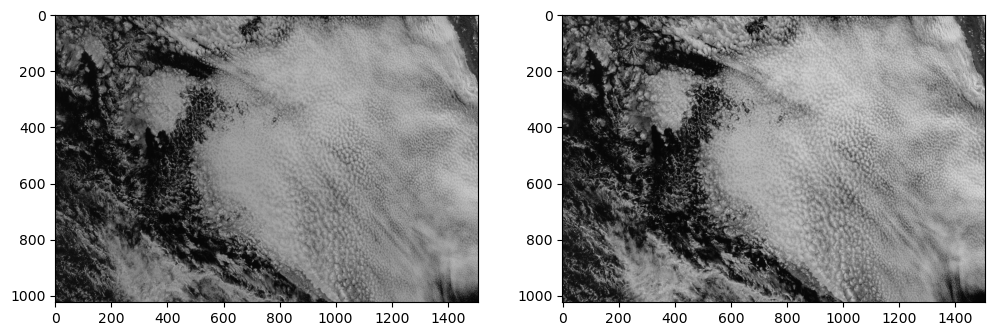

In [4]:
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

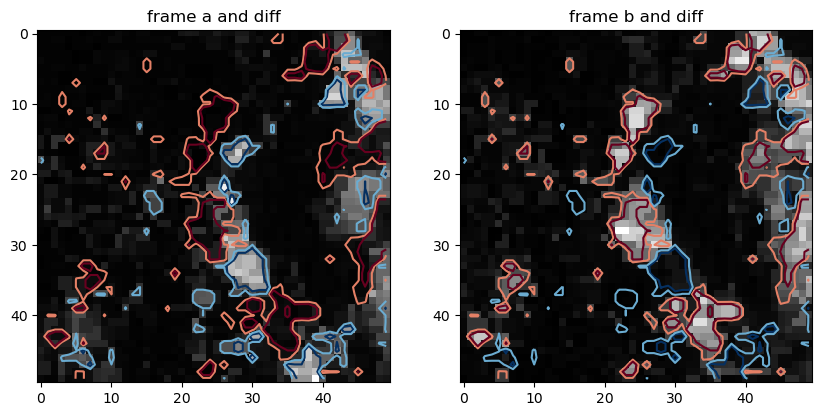

In [5]:
# Difference is mostly advection (+/- downwind dipoles)

box = (slice(500,550,1), slice(350,400,1) )

plt.figure(figsize=[10,5])

plt.subplot(1, 2, 1)
plt.imshow(frame_a[box],cmap=plt.cm.gray); plt.title('frame a and diff')
plt.contour((frame_b-frame_a)[box],levels=[-50,-25,25,50], cmap='RdBu_r')

plt.subplot(1, 2, 2)
plt.imshow(frame_b[box],cmap=plt.cm.gray); plt.title('frame b and diff')
plt.contour((frame_b-frame_a)[box],levels=[-50,-25,25,50], cmap='RdBu_r')

# plt.colorbar()

In [7]:
# Original: 
winsize = 32 # pixels, interrogation window size in frame A
searchsize = 48  # pixels, search in image B big enough to contain credible velocity 
overlap = 16 # pixels, 50% overlap if half of winsize
dt = 1 # time interval between pulses, converts pixel displacement to velocity

# BEM Experiments: 
#winsize = 64 # pixels, interrogation window size in frame A
#searchsize = 75  # pixels, search in image B
#overlap = 12 # pixels, 50% overlap
#dt = 60*30 # sec, time interval between imagesdt

pyprocess.get_field_shape(frame_a.shape, searchsize, overlap)

array([31, 46])

In [8]:
np.array(frame_a.shape) 

array([1024, 1508])

In [9]:
np.array(searchsize)

array(48)

In [10]:
np.array(frame_a.shape) - np.array(searchsize) # oh broadcasts 1D to 2D 

array([ 976, 1460])

In [11]:
np.array(searchsize) - np.array(overlap)

32

In [ ]:
print('did it skip')
u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')
print('yes')

did it skip


In [ ]:
#pyprocess.extended_search_area_piv?

In [ ]:
#pyprocess.get_coordinates?

In [ ]:
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

In [ ]:
x.shape, x.min(), x.max(), x.mean()

In [ ]:
#centers of velocity 
y.min(), y.max(), y.mean()

In [ ]:
frame_a.shape

In [ ]:
31*winsize, 46*winsize  # confirming the squares don't quite cover the rectangle 

In [ ]:
u1, v1, mask = validation.sig2noise_val( u0, v0, 
                                        sig2noise, 
                                        threshold = 1.05) #1.05 )
# if you need more detailed look, first create a histogram of sig2noise
# plt.hist(sig2noise.flatten())
# to see where is a reasonable limit

In [ ]:
plt.hist(sig2noise.flatten())

In [ ]:
u1.shape

In [ ]:
filters.replace_outliers?

In [ ]:
# filter out outliers that are very different from the
# neighbours

u2, v2 = filters.replace_outliers( u1, v1, 
                                  method='localmean', 
                                  max_iter=5, 
                                  kernel_size=5)


In [ ]:
x.shape, x.min(), x.max(), x.mean()

In [ ]:
# tools.transform_coordinates?

In [ ]:
# convert x,y to mm
# convert u,v to mm/sec

x3, y3, u3, v3 = scaling.uniform(x, y, u2, v2, 
                               scaling_factor = 96.52 ) # 96.52 microns/pixel

# image coords to xy coords: 0,0 shall be bottom left, positive rotation rate is counterclockwise
x3, y3, u3, v3 = tools.transform_coordinates(x3, y3, u3, v3)

In [ ]:
#save in the simple ASCII table format
tools.save(x3, y3, u3, v3, mask, 'exp1_001.txt' )

In [ ]:
u3.shape

In [ ]:
# Display from that file 
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field('exp1_001.txt', 
                           ax=ax, scaling_factor=96.52, 
                           scale=2, # scale defines here the arrow length, but inversely
                           width=0.0035, # width is the thickness of the arrow
                           on_img=True, # overlay on the first image
                           image_name='DATA/image_0_2022_09_06_15_15_00Z.png');

In [ ]:
u3.shape

In [ ]:
# tools.display_windows_sampling(x, y, window_size=32, skip=0, method='standard')

In [ ]:
#from IPython.display import Video
# Video("DATA/closedcellday_2022_09_06.mp4", embed=True)

# https://github.com/brianmapes/stratocu_waves/blob/main/DATA/closedcellday_2022_09_06.mp4

## Let's try to build forecasted imageb as I want, from this 

In [ ]:
# Display from that file 
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field('exp1_001.txt', 
                           ax=ax, scaling_factor=96.52, 
                           scale=100, # scale defines here the arrow length, but inversely
                           width=0.0035, # width is the thickness of the arrow
                           on_img=True, # overlay on the first image
                           image_name='DATA/image_0_2022_09_06_15_15_00Z.png');

# Stay safe down here

In [ ]:
plt.imshow(mask)

In [ ]:
# building from https://openpiv.readthedocs.io/en/latest/_modules/openpiv/tools.html#display_vector_field

# have    x, y, u, v, mask = a[:, 0], a[:, 1], a[:, 2], a[:, 3], a[:, 4]

# New variables (all checked, none exist above) 
window_size=32
scaling_factor=1
widim=False
width=0.0025
im = frame_a
xmax = np.amax(x) + window_size / (2 * scaling_factor)
ymax = np.amax(y) + window_size / (2 * scaling_factor)

fig, ax = plt.subplots()
#ax.imshow(im, cmap="Greys_r", extent=[0.0, xmax, 0.0, ymax])

invalid = mask.astype("bool")  
valid = ~invalid

#if len(x[invalid]) > 0:  
#    ax.quiver(
#            x[invalid], y[invalid], u3[invalid], v3[invalid], \
#            color="r", width=width)

#all arrows
ax.quiver(x, y, u3, v3, color="r") #, width=width)

#masked ones
ax.quiver(x[valid], y[valid], u3[valid], v3[valid], \
        color="b") #, width=width)


#ax.set_aspect(1.)